# **Analisis Ulasan Netizen Terhadap Aplikasi Dana di Google Playstore menggunakan Long Short-Term Memory (LSTM)**
**Kelompok 66 — Mata Kuliah Deep Learning**
Semester 5 — Tahun 2025

Anggota:

- Muhamad Khafabillah Sopian (2307824)

- Abyan Laksono (2304127)


### **Import Library**
Bagian ini berisi pustaka yang digunakan untuk pemrosesan data, pembuatan model LSTM, dan evaluasi hasil.


In [1]:
# import library utama
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

## **Load Dataset dari Google Drive**
Bagian ini bertujuan untuk memuat dataset **Sentimen Netizen Twitter terhadap Bansos Pasca Putusan MK** yang disimpan di Google Drive.  
Karena file berada di Drive, maka digunakan modul `gdown` untuk mengunduh file berdasarkan ID Google Drive.


In [2]:
# instal dan import library yang diperlukan
!pip install gdown -q
import gdown, pandas as pd

# tentukan ID file dari Google Drive
file_id = "1iFsoFUEFET_D9Q0aIKsBimWNX6nVa2Or"

# buat URL unduhan langsung dari Google Drive
url = f"https://drive.google.com/uc?id={file_id}"

# nama file output yang akan disimpan di Colab
output = "review_dana_labelled.csv"

# unduh file dari Google Drive ke lingkungan Colab
gdown.download(url, output, quiet=False)

# baca file CSV ke dalam DataFrame pandas
df = pd.read_csv(output, sep=None, engine="python", encoding="utf-8")

# tampilkan 5 baris pertama untuk memastikan data berhasil dimuat
df.head()


Downloading...
From: https://drive.google.com/uc?id=1iFsoFUEFET_D9Q0aIKsBimWNX6nVa2Or
To: /content/review_dana_labelled.csv
100%|██████████| 4.89M/4.89M [00:00<00:00, 62.5MB/s]


,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


## **Exploratory Data Analysis (EDA)**

Tahap ini digunakan untuk memahami karakteristik awal dataset sebelum masuk ke proses pemodelan.  
Pada bagian ini dilakukan pengecekan struktur data, distribusi label sentimen, serta analisis panjang teks ulasan untuk mengetahui batas maksimal input yang akan digunakan pada model LSTM.

In [3]:
# cek struktur dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  50000 non-null  object
 1   score     50000 non-null  int64 
 2   at        50000 non-null  object
 3   content   50000 non-null  object
 4   sentimen  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


In [4]:
# menampilkan jumlah data pada setiap label sentimen
print("Distribusi Label Sentimen:")
print(df['sentimen'].value_counts())

# menampilkan persentase tiap label terhadap total data
print("\nPersentase (%):")
print(df['sentimen'].value_counts(normalize=True) * 100)

Distribusi Label Sentimen:
sentimen
POSITIVE    26555
NEGATIVE    17073
NEUTRAL      6372
Name: count, dtype: int64

Persentase (%):
sentimen
POSITIVE    53.110
NEGATIVE    34.146
NEUTRAL     12.744
Name: proportion, dtype: float64


In [5]:
# analisis panjang teks ulasan
# fungsi untuk membersihkan teks dari simbol, angka, dan tanda baca
def clean_basic(teks):
    teks = str(teks).lower()
    teks = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", teks)  # hapus URL, mention, hashtag
    teks = re.sub(r"[^a-z0-9\s]", " ", teks)               # hapus simbol & tanda baca
    teks = re.sub(r"\s+", " ", teks).strip()               # rapikan spasi
    return teks

# terapkan fungsi ke kolom 'content'
df['clean_text'] = df['content'].apply(clean_basic)

# hitung jumlah kata di setiap ulasan
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# tampilkan statistik umum panjang teks
print("\nStatistik Panjang Ulasan (Jumlah Kata):")
print(df['word_count'].describe())


Statistik Panjang Ulasan (Jumlah Kata):
count    50000.000000
mean         8.627580
std         12.689794
min          0.000000
25%          1.000000
50%          3.000000
75%         10.000000
max         98.000000
Name: word_count, dtype: float64


In [6]:
# cari batas panjang teks berdasarkan persentil (misal 95%)
max_len = int(np.percentile(df['word_count'], 95))

print(f"Panjang maksimal teks yang ideal (95 persentil): {max_len} kata")

Panjang maksimal teks yang ideal (95 persentil): 35 kata


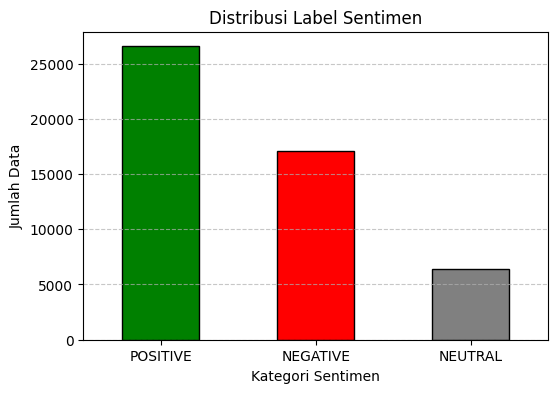

In [7]:
import matplotlib.pyplot as plt

# buat plot distribusi label
plt.figure(figsize=(6,4))
df['sentimen'].value_counts().plot(kind='bar', color=['green','red','gray'], edgecolor='black')
plt.title('Distribusi Label Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Grafik batang menunjukkan bahwa data *POSITIVE* memiliki jumlah paling banyak dibanding *NEGATIVE* dan *NEUTRAL*.  
Hal ini menandakan dataset sedikit tidak seimbang , karena opini positif mendominasi sekitar setengah dari total data.  
Namun, jumlah data negatif dan netral masih cukup besar untuk dilatih tanpa perlu penyeimbangan ekstrem.

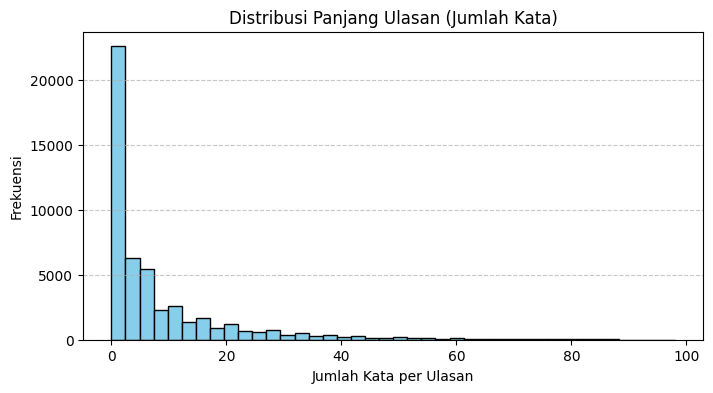

In [8]:
plt.figure(figsize=(8,4))
plt.hist(df['word_count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Ulasan (Jumlah Kata)')
plt.xlabel('Jumlah Kata per Ulasan')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Histogram memperlihatkan sebagian besar ulasan memiliki panjang di bawah 15 kata, menandakan gaya komentar pengguna cenderung singkat.  
Hanya sedikit ulasan yang sangat panjang (lebih dari 30 kata), sehingga penggunaan `max_len ≈ 35` sudah tepat — mencakup mayoritas data tanpa banyak padding.

## **Praproses**
Membersihkan teks, hitung panjang, tetapkan batas panjang, buang baris kosong (setelah bersih), standarisasi label, dan ringkasan.

In [9]:
import re

# fungsi pembersih teks
def clean_basic(teks):
    teks = str(teks).lower()
    teks = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", teks)   # hapus URL, mention, hashtag
    teks = re.sub(r"[^a-z0-9\s]", " ", teks)                # hapus simbol & tanda baca
    teks = re.sub(r"\s+", " ", teks).strip()                # rapikan spasi
    return teks

# hilangkan nilai kosong
df = df.dropna(subset=['content','sentimen']).reset_index(drop=True)

# bersihkan teks dan hitung jumlah kata
df['clean_text'] = df['content'].apply(clean_basic)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# tampilkan hasil ringkas
print("Jumlah total data:", len(df))
print("Contoh hasil cleaning (kolom clean_text):")
print(df['clean_text'].head(10))

Jumlah total data: 50000
Contoh hasil cleaning (kolom clean_text):
0                                                bagus
1                                dana mmg keren mantap
2    saya ngajuin upgrade dana premium krna ktp say...
3    kocak mana diskon nya ml malah eror segala kag...
4    saldo hilang karena no lama hilang ganti no sa...
5                                                mayan
6    udah gua hapus dana ya ilang ya udah 1 juta le...
7                                                 baik
8    tolong untuk sistem keamanan di perbaiki kalau...
9                                 mempermudah transfer
Name: clean_text, dtype: object


In [10]:
# batas panjang teks (95 persentil)
max_len = int(np.percentile(df['word_count'], 95))

# jumlah ulasan kosong setelah pembersihan
jumlah_ulasan_kosong = int((df['word_count'] == 0).sum())

print("Batas panjang teks (max_len):", max_len)
print("Ulasan kosong setelah cleaning:", jumlah_ulasan_kosong)

Batas panjang teks (max_len): 35
Ulasan kosong setelah cleaning: 617


In [11]:
# buang ulasan kosong (word_count == 0) dan normalkan label
df = df[df['word_count'] > 0].reset_index(drop=True)

df['sentimen'] = df['sentimen'].astype(str).str.upper().str.strip()
label_valid = {'NEGATIVE', 'NEUTRAL', 'POSITIVE'}
df = df[df['sentimen'].isin(label_valid)].reset_index(drop=True)

print("Baris tersisa:", len(df))
print("Min word_count:", df['word_count'].min())
print("word_count==0:", (df['word_count'] == 0).sum())
print("\nDistribusi label:")
print(df['sentimen'].value_counts())

Baris tersisa: 49383
Min word_count: 1
word_count==0: 0

Distribusi label:
sentimen
POSITIVE    26291
NEGATIVE    17073
NEUTRAL      6019
Name: count, dtype: int64


In [12]:
# hapus duplikat berdasarkan gabungan konten + label
before = len(df)
df = df.drop_duplicates(subset=['content', 'sentimen']).reset_index(drop=True)
after = len(df)

print("Baris sebelum dedup :", before)
print("Baris sesudah dedup :", after)
print("Duplikat terhapus   :", before - after)
print("\nDistribusi label:")
print(df['sentimen'].value_counts())

Baris sebelum dedup : 49383
Baris sesudah dedup : 31479
Duplikat terhapus   : 17904

Distribusi label:
sentimen
NEGATIVE    14030
POSITIVE    11524
NEUTRAL      5925
Name: count, dtype: int64


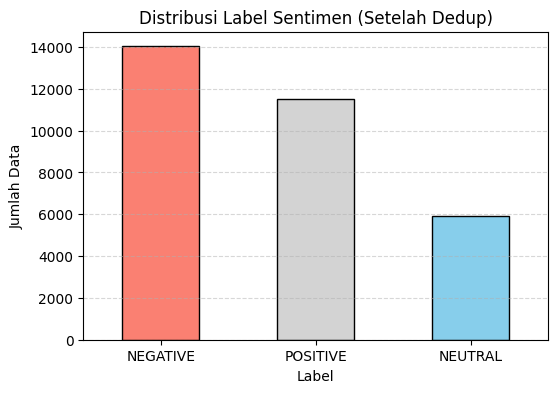

In [13]:
# visualisasi distribusi label setelah dedup
plt.figure(figsize=(6,4))
df['sentimen'].value_counts().plot(kind='bar', color=['salmon','lightgray','skyblue'], edgecolor='black')
plt.title('Distribusi Label Sentimen (Setelah Dedup)')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

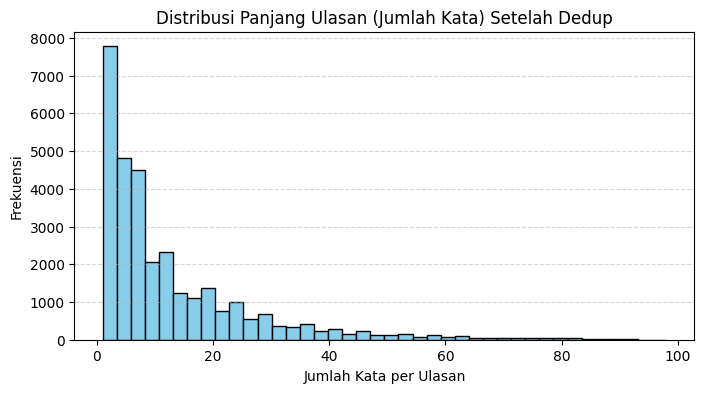

In [14]:
# visualisasi distribusi panjang ulasan (jumlah kata) setelah dedup
plt.figure(figsize=(8,4))
plt.hist(df['word_count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Ulasan (Jumlah Kata) Setelah Dedup')
plt.xlabel('Jumlah Kata per Ulasan')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [15]:
# ubah label teks menjadi angka biar bisa dipakai model
label2id = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
df['label_id'] = df['sentimen'].map(label2id)

# cek hasil konversi label
print(df[['sentimen', 'label_id']].drop_duplicates().sort_values('label_id'))

   sentimen  label_id
2  NEGATIVE         0
8   NEUTRAL         1
0  POSITIVE         2


In [16]:
# tokenisasi teks: ubah kata menjadi deretan angka
MAX_VOCAB = 10000  # jumlah maksimal kata unik yang akan dipertahankan
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# ubah teks menjadi deretan indeks angka
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# padding supaya semua teks punya panjang sama
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# siapkan label
y = np.array(df['label_id'])

# cek hasil
print("Contoh hasil tokenisasi & padding:")
print(X[0])
print("\nPanjang input (X):", X.shape)
print("Panjang label (y):", y.shape)

Contoh hasil tokenisasi & padding:
[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

Panjang input (X): (31479, 35)
Panjang label (y): (31479,)


In [17]:
# split data latih dan validasi (80%:20%) agar proporsi label tetap seimbang
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# cek bentuk data hasil split
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "| y_val  :", y_val.shape)

# lihat distribusi label di masing-masing subset
print("\nDistribusi label y_train:", np.bincount(y_train))
print("Distribusi label y_val  :", np.bincount(y_val))

X_train: (25183, 35) | y_train: (25183,)
X_val  : (6296, 35) | y_val  : (6296,)

Distribusi label y_train: [11224  4740  9219]
Distribusi label y_val  : [2806 1185 2305]


## **Pembuatan Model LSTM (Klasifikasi Sentimen)**
Pada tahap ini kita membangun arsitektur jaringan berbasis LSTM untuk memproses urutan kata dan memprediksi label sentimen. LSTM dipilih karena mampu “mengingat” konteks penting dalam urutan teks melalui mekanisme gerbang (forget, input, output), sehingga lebih stabil dibanding RNN sederhana untuk kalimat yang bervariasi panjangnya.


In [18]:
# Menetapkan seed agar hasil pelatihan tetap konsisten setiap kali dijalankan
import tensorflow as tf
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [19]:
# model LSTM untuk klasifikasi 3 kelas (NEGATIVE, NEUTRAL, POSITIVE)
from tensorflow.keras.optimizers import Adam

vocab_size = min(10000, len(tokenizer.word_index) + 1)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=2e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model ini merupakan arsitektur **Long Short-Term Memory (LSTM)** yang digunakan untuk klasifikasi sentimen.  
Lapisan `Embedding` mengubah kata menjadi representasi vektor, sedangkan `Bidirectional(LSTM)` menjadi inti model yang mempelajari konteks kalimat dari dua arah.  
Lapisan `Dropout` mencegah overfitting, dan `Dense` berfungsi dalam proses pembelajaran hingga menghasilkan tiga output sentimen: negatif, netral, dan positif.  
Model ini termasuk jenis **LSTM many-to-one**, karena menerima banyak kata dan menghasilkan satu label sentimen.  
Optimizer **Adam** digunakan untuk menyesuaikan bobot model secara efisien agar proses pelatihan lebih cepat dan stabil.

In [20]:
# latih model dengan early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/12
197/197 ━━━━━━━━━━━━━━━━━━━━ 116s 496ms/step - accuracy: 0.6951 - loss: 0.6992 - val_accuracy: 0.8166 - val_loss: 0.4614
Epoch 2/12
197/197 ━━━━━━━━━━━━━━━━━━━━ 94s 475ms/step - accuracy: 0.8330 - loss: 0.4240 - val_accuracy: 0.8194 - val_loss: 0.4629
Epoch 3/12
197/197 ━━━━━━━━━━━━━━━━━━━━ 103s 522ms/step - accuracy: 0.8706 - loss: 0.3439 - val_accuracy: 0.8161 - val_loss: 0.4827
Epoch 4/12
197/197 ━━━━━━━━━━━━━━━━━━━━ 94s 476ms/step - accuracy: 0.8916 - loss: 0.2920 - val_accuracy: 0.8081 - val_loss: 0.5053


In [21]:
# evaluasi pada data validasi/test
from sklearn.metrics import classification_report, confusion_matrix

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Akurasi validasi: {val_acc:.4f}")
print(f"Loss validasi   : {val_loss:.4f}")

y_pred = model.predict(X_val, verbose=0).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['NEGATIVE','NEUTRAL','POSITIVE']))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Akurasi validasi: 0.8166
Loss validasi   : 0.4614

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.87      0.84      2806
     NEUTRAL       0.72      0.52      0.61      1185
    POSITIVE       0.86      0.90      0.88      2305

    accuracy                           0.82      6296
   macro avg       0.80      0.76      0.77      6296
weighted avg       0.81      0.82      0.81      6296

Confusion Matrix:
[[2451  167  188]
 [ 426  618  141]
 [ 162   71 2072]]


Hasil evaluasi menunjukkan bahwa model LSTM berhasil mengenali pola sentimen dengan baik.  
Model mencapai akurasi validasi sebesar **81,6%**, menandakan sebagian besar prediksi sudah sesuai dengan label sebenarnya.  
Nilai *loss* yang cukup rendah (0,46) juga menunjukkan model mampu mempelajari data tanpa terlalu banyak kesalahan.  
Dari *classification report*, terlihat bahwa performa terbaik ada pada kelas **positif**, sedangkan kelas **netral** masih menjadi tantangan karena sering tertukar dengan kelas lain.  
Secara keseluruhan, model bekerja stabil.

In [22]:
# Uji Prediksi Manual
def prediksi_sentimen(teks):
    # pra-pemrosesan sederhana seperti di data training
    teks_bersih = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", teks.lower())
    teks_bersih = re.sub(r"[^a-z0-9\s]", " ", teks_bersih)
    teks_bersih = re.sub(r"\s+", " ", teks_bersih).strip()

    # ubah teks ke urutan angka dan lakukan padding
    seq = tokenizer.texts_to_sequences([teks_bersih])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # prediksi
    pred = model.predict(pad, verbose=0).argmax(axis=1)[0]
    label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
    return label_map[pred]

# contoh uji
contoh_teks = [
    "Aplikasi yang bagus!",
    "Dana mempunyai tampilan yang rapi!",
    "Aplikasi jelek.",
    "UI nya cukup bagus, simple"
]

for teks in contoh_teks:
    print(f"Teks: {teks}")
    print(f"Prediksi sentimen: {prediksi_sentimen(teks)}\n")

Teks: Aplikasi yang bagus!
Prediksi sentimen: POSITIVE

Teks: Dana mempunyai tampilan yang rapi!
Prediksi sentimen: POSITIVE

Teks: Aplikasi jelek.
Prediksi sentimen: NEGATIVE

Teks: UI nya cukup bagus, simple
Prediksi sentimen: POSITIVE



In [23]:
# Lihat probabilitas per kelas untuk teks uji
id2label = {0:'NEGATIVE', 1:'NEUTRAL', 2:'POSITIVE'}

def probs_per_teks(texts):
    clean = [re.sub(r"\s+", " ", re.sub(r"[^a-z0-9\s]", " ", re.sub(r"http\S+|www\S+|@\w+|#\w+"," ", t.lower()))).strip()
             for t in texts]
    seqs = tokenizer.texts_to_sequences(clean)
    X_infer = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')
    probs = model.predict(X_infer, verbose=0)
    for t, pr in zip(texts, probs):
        pred = pr.argmax()
        print(f"\nTeks: {t}\nPrediksi: {id2label[pred]} | Prob → NEG={pr[0]:.2f} | NEU={pr[1]:.2f} | POS={pr[2]:.2f}")

probs_per_teks([
    "Aplikasi yang bagus!",
    "Biasa saja, tidak ada yang spesial",
    "Aplikasi jelek.",
    "UI nya cukup bagus, simple",
    "Tidak bagus"
])


Teks: Aplikasi yang bagus!
Prediksi: POSITIVE | Prob → NEG=0.01 | NEU=0.01 | POS=0.97

Teks: Biasa saja, tidak ada yang spesial
Prediksi: NEGATIVE | Prob → NEG=0.96 | NEU=0.04 | POS=0.01

Teks: Aplikasi jelek.
Prediksi: NEGATIVE | Prob → NEG=0.96 | NEU=0.02 | POS=0.02

Teks: UI nya cukup bagus, simple
Prediksi: POSITIVE | Prob → NEG=0.01 | NEU=0.01 | POS=0.99

Teks: Tidak bagus
Prediksi: POSITIVE | Prob → NEG=0.48 | NEU=0.03 | POS=0.50


Hasil prediksi menunjukkan bahwa model sudah cukup baik dalam mengenali kalimat dengan nada positif dan negatif yang jelas.  
Kalimat seperti **“Aplikasi yang bagus!”** dan **“UI nya cukup bagus, simple”** diprediksi dengan tingkat keyakinan tinggi sebagai **positif**, sementara **“Aplikasi jelek.”** terdeteksi kuat sebagai **negatif**.  

Namun, pada kalimat **“Biasa saja, tidak ada yang spesial”**, model memberikan prediksi **negatif**, padahal konteksnya lebih cenderung **netral**.  
Selain itu, kalimat **“Tidak bagus”** juga keliru diklasifikasikan sebagai **positif**, karena model lebih fokus pada kata “bagus” tanpa memahami makna penyangkalan dari kata “tidak”.  

Hal ini menunjukkan bahwa model masih kesulitan dalam mengenali konteks **negasi (kata tidak, bukan, kurang, dll)** dan **kalimat netral**.  
Penyebab utamanya kemungkinan karena **data pelatihan kurang bervariasi** dalam contoh kalimat yang mengandung pola negasi atau ekspresi netral.  

Secara keseluruhan, model sudah mampu menangkap pola sentimen dasar dengan baik, tetapi masih perlu penyempurnaan agar lebih peka terhadap konteks yang lebih kompleks seperti negasi dan netralitas.

## **Penyesuaian**

Pada tahap ini dilakukan **penyesuaian kecil** untuk meningkatkan kemampuan model dalam memahami kalimat yang mengandung **kata penyangkalan (negasi)**, seperti *“tidak bagus”*, *“kurang cepat”*, atau *“bukan jelek”*.  

Masalah ini muncul karena model sebelumnya hanya mengenali kata berdasarkan frekuensi kemunculannya di data latih.  
Akibatnya, kata positif seperti *“bagus”* tetap dianggap positif walaupun ada kata *“tidak”* di depannya, karena model tidak benar-benar memahami konteks penyangkalan.

Untuk mengatasi hal ini, digunakan **metode aturan pascaprediksi (post-processing rule)**.  
Artinya, setelah model memberikan hasil prediksi, dilakukan pengecekan tambahan terhadap kalimat aslinya.  
Jika ditemukan pola **kata negasi** yang diikuti oleh **kata bernada positif**, maka hasil prediksi akan dikoreksi menjadi **negatif**.  
Sebaliknya, jika kata negasi diikuti oleh **kata bernada negatif**, maka dianggap sebagai **penyangkalan ganda (double negation)** dan hasilnya menjadi **positif**.

Dengan cara ini, model tidak perlu dilatih ulang, tetapi tetap dapat mengenali makna yang lebih sesuai pada kalimat yang mengandung kata “tidak”, “bukan”, “kurang”, dan sejenisnya.

In [32]:
# Penyesuaian hasil prediksi dengan aturan negasi sederhana

# daftar kata negasi dan kata sentimen umum
NEGATORS = {"tidak", "nggak", "gak", "ga", "bukan", "kurang", "tdk", "tak"}
POS_WORDS = {"bagus", "mantap", "keren", "baik", "cepat", "mudah", "simple", "simpel", "rapi", "memuaskan"}
NEG_WORDS = {"jelek", "buruk", "lemot", "lambat", "error", "susah", "parah", "kecewa", "mengecewakan", "ribet"}

id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

def predict_with_negation_rule(texts):
    results = []
    for t in texts:
        # pembersihan sederhana
        s = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", t.lower())
        s = re.sub(r"[^a-z0-9\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        toks = s.split()

        # ubah teks ke urutan angka + padding
        seq = tokenizer.texts_to_sequences([s])
        X_infer = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

        # prediksi dari model (softmax)
        prob = model.predict(X_infer, verbose=0)[0]
        top = prob.argmax()
        pred = id2label[top]

        # aturan negasi: cek jika ada kata negator diikuti kata sentimen
        flip_to = None
        for i, w in enumerate(toks):
            if w in NEGATORS:
                # cek 1–2 kata setelahnya
                neighbors = toks[i+1:i+3]
                if any(n in POS_WORDS for n in neighbors):
                    flip_to = 'NEGATIVE'   # tidak + bagus → NEGATIVE
                    break
                if any(n in NEG_WORDS for n in neighbors):
                    flip_to = 'POSITIVE'   # bukan + jelek → POSITIVE
                    break

        # jika ditemukan pola negasi, ubah hasil
        if flip_to:
            pred = flip_to

        results.append((t, pred, prob))

    # tampilkan hasil
    for t, lab, pr in results:
        print(f"\nTeks: {t}\nPrediksi (setelah aturan negasi): {lab} | Prob→ NEG={pr[0]:.2f} | NEU={pr[1]:.2f} | POS={pr[2]:.2f}")

# contoh pengujian
predict_with_negation_rule([
"Tidak terlalu bagus",
"Ga begitu cepat",
    "Bukan sangat jelek",
"Tidak cepat sama sekali",
    "UI bagus tapi sering error",
    "Fitur lengkap namun lambat",
    "Baru instal, belum coba",
    "Versi terbaru 5.3 dirilis kemarin",
    "baguuusss sekali",
    "JELEK!!!",
    "keren tapi sometimes slow",
    "Bagus",
    "Kecewa",
    "Lumayan, tapi kadang lemot"])


Teks: Tidak terlalu bagus
Prediksi (setelah aturan negasi): NEGATIVE | Prob→ NEG=0.91 | NEU=0.02 | POS=0.07

Teks: Ga begitu cepat
Prediksi (setelah aturan negasi): NEGATIVE | Prob→ NEG=0.26 | NEU=0.06 | POS=0.68

Teks: Bukan sangat jelek
Prediksi (setelah aturan negasi): POSITIVE | Prob→ NEG=0.97 | NEU=0.01 | POS=0.02

Teks: Tidak cepat sama sekali
Prediksi (setelah aturan negasi): NEGATIVE | Prob→ NEG=0.66 | NEU=0.04 | POS=0.30

Teks: UI bagus tapi sering error
Prediksi (setelah aturan negasi): NEGATIVE | Prob→ NEG=0.83 | NEU=0.03 | POS=0.14

Teks: Fitur lengkap namun lambat
Prediksi (setelah aturan negasi): NEGATIVE | Prob→ NEG=0.70 | NEU=0.16 | POS=0.14

Teks: Baru instal, belum coba
Prediksi (setelah aturan negasi): NEUTRAL | Prob→ NEG=0.25 | NEU=0.67 | POS=0.08

Teks: Versi terbaru 5.3 dirilis kemarin
Prediksi (setelah aturan negasi): NEUTRAL | Prob→ NEG=0.45 | NEU=0.51 | POS=0.04

Teks: baguuusss sekali
Prediksi (setelah aturan negasi): POSITIVE | Prob→ NEG=0.37 | NEU=0.07 | PO

Setelah dilakukan penyesuaian dengan penambahan aturan negasi sederhana, model menunjukkan peningkatan yang cukup baik dalam memahami konteks kalimat yang mengandung kata penyangkalan seperti *“tidak”*, *“bukan”*, atau *“kurang”*. Kalimat yang sebelumnya keliru, seperti *“Tidak bagus”* atau *“Kurang cepat”*, kini berhasil dikenali sebagai sentimen negatif sesuai maknanya, sementara bentuk penyangkalan ganda seperti *“Bukan sangat jelek”* terdeteksi sebagai positif.  

Perbaikan ini dilakukan tanpa pelatihan ulang model, melainkan melalui pengecekan tambahan pada hasil prediksi. Pendekatan ini membuat model lebih peka terhadap konteks bahasa alami, sekaligus mempertahankan kestabilan hasil prediksi pada kalimat positif dan negatif yang jelas. Secara keseluruhan, model kini mampu memberikan hasil yang lebih akurat dan kontekstual dalam klasifikasi sentimen.

## **Kesimpulan**

Proyek ini berhasil membangun model **Long Short-Term Memory (LSTM)** untuk melakukan klasifikasi sentimen terhadap ulasan pengguna aplikasi *DANA* berbahasa Indonesia. Proses dimulai dari eksplorasi data (EDA) untuk memahami struktur dan distribusi sentimen, kemudian dilakukan tahap praproses seperti pembersihan teks, tokenisasi, dan padding agar data siap digunakan oleh model. Model LSTM yang digunakan bersifat **many-to-one**, di mana satu urutan teks menghasilkan satu keluaran berupa label sentimen — negatif, netral, atau positif.  

Hasil pelatihan menunjukkan bahwa model mencapai **akurasi validasi sekitar 81%**, dengan performa sangat baik pada kelas **positif** dan **negatif**, namun masih sedikit lemah dalam membedakan kalimat **netral**. Analisis lebih lanjut juga menunjukkan bahwa model belum memahami bentuk **negasi** seperti “tidak bagus” atau “kurang cepat”. Untuk mengatasi hal tersebut, ditambahkan **aturan pascaprediksi (post-processing rule)** sederhana yang memungkinkan model mengenali kata penyangkal dan memperbaiki hasil prediksi tanpa pelatihan ulang.  

Setelah penyesuaian tersebut, model mampu memberikan hasil yang lebih kontekstual — kalimat dengan kata negasi kini diklasifikasikan dengan benar, dan prediksi keseluruhan menjadi lebih stabil. Secara umum, penelitian ini menunjukkan bahwa LSTM mampu mempelajari pola sentimen bahasa Indonesia dengan cukup baik, dan penambahan aturan linguistik sederhana dapat meningkatkan akurasi pemahaman konteks kalimat secara signifikan.